**Data preprocess**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
customer_sales = pd.read_excel('merged_customer_sales.xlsx')
landing_pages = pd.read_csv('MIS384 Landing Pages.csv')
marketing_spend = pd.read_csv('MIS384 Marketing Spend.csv')
discount_coupon = pd.read_csv('MIS384 Marketing Analytics Discount Coupon.csv')
customer_profile = pd.read_csv('Customer Profile - MIS384 Marketing Analytics.csv')

In [ ]:
# Data preparation
customer_sales['Transaction_Date'] = pd.to_datetime(customer_sales['Transaction_Date'])
customer_sales['Month'] = customer_sales['Transaction_Date'].dt.month
customer_sales['Year'] = customer_sales['Transaction_Date'].dt.year
customer_sales['Revenue'] = customer_sales['Quantity'] * customer_sales['Avg_Price']

marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])
marketing_spend['Month'] = marketing_spend['Date'].dt.month
marketing_spend['Year'] = marketing_spend['Date'].dt.year

# Properly handle landing_pages Date column
landing_pages_columns = landing_pages.columns.tolist()
date_column = [col for col in landing_pages_columns if col.lower() == 'date'][0]
landing_pages['Date_Formatted'] = pd.to_datetime(landing_pages[date_column].astype(str), format='%Y%m%d', errors='coerce')

**Section 0: Business Overview**

Total Revenue: $3,036,939.84
Total Unique Customers: 1,464
Total Transactions: 49,292
Average Transaction Value: $61.61
Average Revenue per Customer: $2,074.41


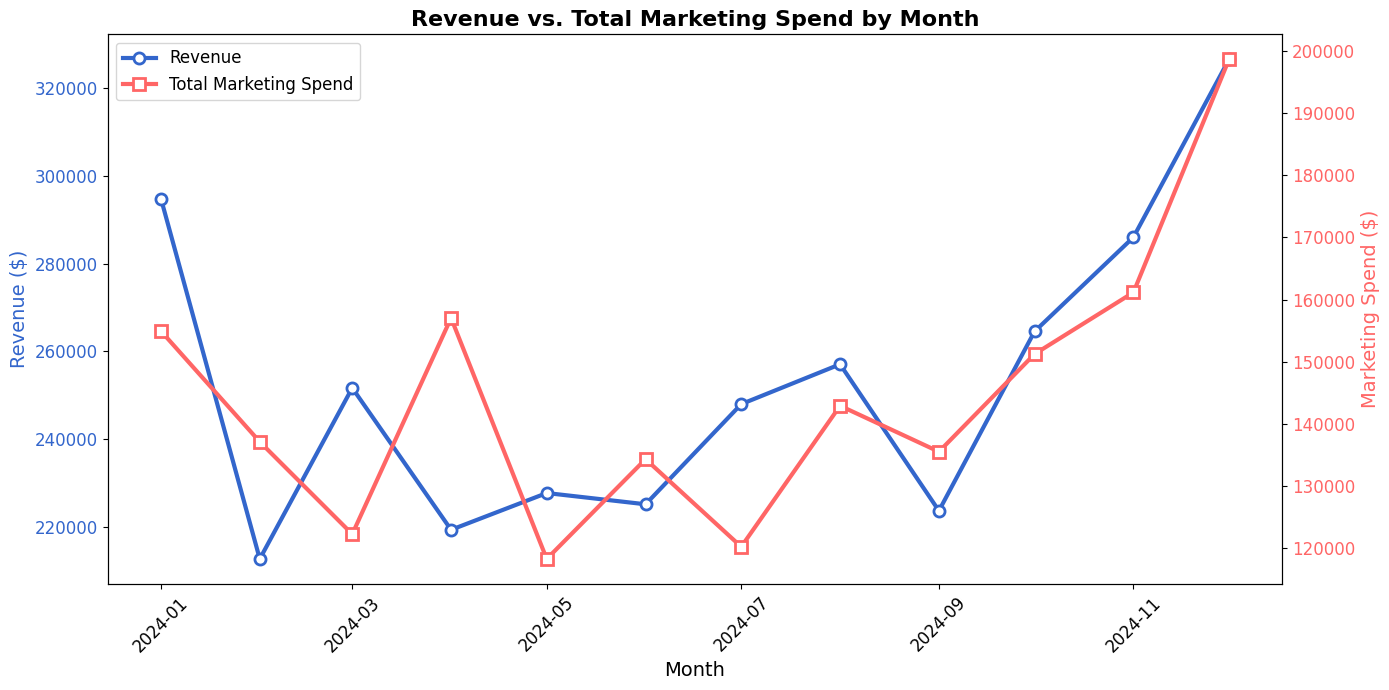


Business Performance Insights:
2. Average Marketing ROI: 76.58%
3. Revenue to Marketing Spend Ratio: 1.75


In [ ]:
# 1. OVERVIEW METRICS
# Calculate key business metrics
total_revenue = customer_sales['Revenue'].sum()
total_customers = customer_sales['CustomerID'].nunique()
total_transactions = customer_sales['Transaction_ID'].count()
avg_transaction_value = total_revenue / total_transactions
avg_revenue_per_customer = total_revenue / total_customers

# Print key metrics
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Unique Customers: {total_customers:,}")
print(f"Total Transactions: {total_transactions:,}")
print(f"Average Transaction Value: ${avg_transaction_value:,.2f}")
print(f"Average Revenue per Customer: ${avg_revenue_per_customer:,.2f}")

# 2. MONTHLY REVENUE TREND
# Monthly revenue trend
monthly_revenue = customer_sales.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
monthly_revenue['Date'] = pd.to_datetime(monthly_revenue['Year'].astype(str) + '-' + monthly_revenue['Month'].astype(str) + '-01')
monthly_revenue = monthly_revenue.sort_values('Date')

# 3. REVENUE VS MARKETING SPEND BY MONTH
# Monthly marketing spend
monthly_marketing = marketing_spend.groupby(['Year', 'Month']).agg({
    'Online_Spend': 'sum',
    'Offline_Spend': 'sum'
}).reset_index()
monthly_marketing['Total_Spend'] = monthly_marketing['Online_Spend'] + monthly_marketing['Offline_Spend']
monthly_marketing['Date'] = pd.to_datetime(monthly_marketing['Year'].astype(str) + '-' + monthly_marketing['Month'].astype(str) + '-01')
monthly_marketing = monthly_marketing.sort_values('Date')

# Plot revenue vs total marketing spend
fig, ax1 = plt.subplots(figsize=(14, 7))

# Revenue line (primary axis)
color1 = '#3366cc'
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Revenue ($)', color=color1, fontsize=14)
ax1.plot(monthly_revenue['Date'], monthly_revenue['Revenue'], color=color1, marker='o',
         linewidth=3, markersize=8, markerfacecolor='white', markeredgewidth=2, label='Revenue')
ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=12)
# ax1.grid(True, alpha=0.3, linestyle='--')

# Marketing spend line (secondary axis)
ax2 = ax1.twinx()
color2 = '#ff6666'
ax2.set_ylabel('Marketing Spend ($)', color=color2, fontsize=14)
ax2.plot(monthly_marketing['Date'], monthly_marketing['Total_Spend'], color=color2, marker='s',
         linewidth=3, markersize=8, markerfacecolor='white', markeredgewidth=2, label='Total Marketing Spend')
ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)

# Title and legend
plt.title('Revenue vs. Total Marketing Spend by Month', fontsize=16, fontweight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

# 5. MARKETING ROI ANALYSIS
# Merge revenue and marketing data
performance_analysis = pd.merge(
    monthly_revenue,
    monthly_marketing,
    on=['Year', 'Month'],
    how='inner',
    suffixes=('_revenue', '_marketing')
)

# Make sure Date column exists after merge
if 'Date' not in performance_analysis.columns:
    performance_analysis['Date'] = pd.to_datetime(
        performance_analysis['Year'].astype(str) + '-' +
        performance_analysis['Month'].astype(str) + '-01'
    )
elif 'Date_revenue' in performance_analysis.columns:
    performance_analysis['Date'] = performance_analysis['Date_revenue']
elif 'Date_marketing' in performance_analysis.columns:
    performance_analysis['Date'] = performance_analysis['Date_marketing']

# Calculate ROAS
performance_analysis['ROAS'] = (performance_analysis['Revenue'] - performance_analysis['Total_Spend']) / performance_analysis['Total_Spend']
performance_analysis['ROAS_Percentage'] = performance_analysis['ROAS'] * 100

# Print summary insights
print("\nBusiness Performance Insights:")
print(f"2. Average Marketing ROI: {performance_analysis['ROAS'].mean()*100:.2f}%")
print(f"3. Revenue to Marketing Spend Ratio: {total_revenue/monthly_marketing['Total_Spend'].sum():.2f}")

In [ ]:
unique_transactions = customer_sales[['CustomerID', 'Transaction_ID']].drop_duplicates()
unique_transactions
# frequency1 = unique_transactions.groupby('CustomerID').size().reset_index(name='Frequency')
# frequency1

,CustomerID,Transaction_ID
0,12346,38223
2,12347,23979
4,12347,23980
5,12347,23981
10,12347,23985
...,...,...
49282,18283,40286
49283,18283,40288
49286,18283,40289
49288,18283,40290


**Top 20% Customer spending -> Analyse the customers with the highest spending**

Identified 293 high-value customers (top 20% by revenue)
High-value threshold: $3122.62
Average spending: High-value=$6118.12, Others=$1062.62


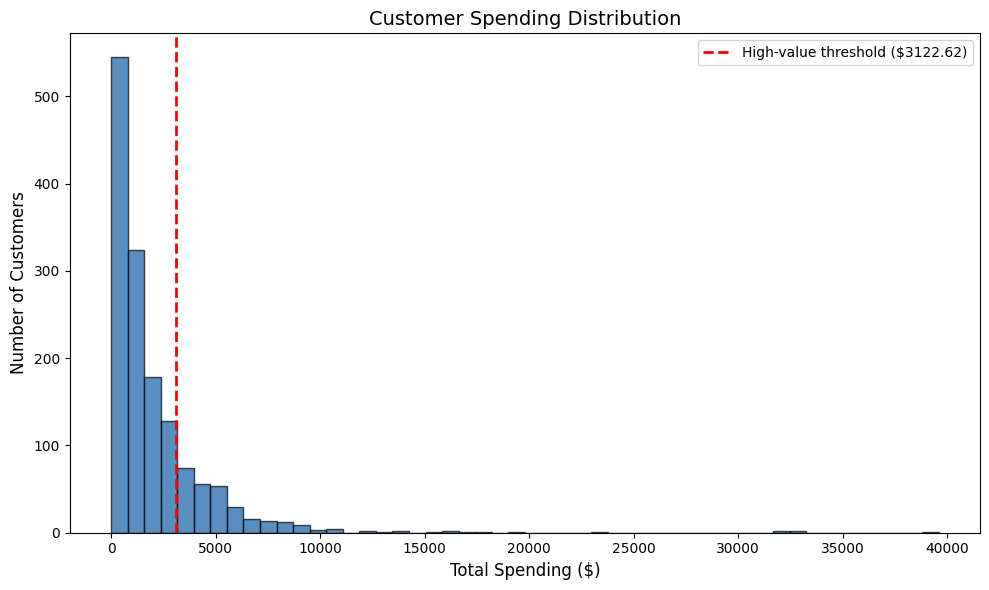


RFM characteristics of high-value customers:
Average recency: 109.8 days
Average frequency: 46.7 transactions
Average monetary: $6118.12


In [ ]:
# Set the style to use Blues_r palette
sns.set_palette("Blues_r")

# Simple approach - identify high-value customers directly without clustering
# Calculate total spending per customer
customer_spending = customer_sales.groupby('CustomerID')['Revenue'].sum()

# Get top 20% customers by revenue (classic 80/20 rule)
high_value_threshold = customer_spending.quantile(0.8)
high_value_customers = customer_spending[customer_spending >= high_value_threshold]

# Save high-value customer IDs
high_value_df = pd.DataFrame({'CustomerID': high_value_customers.index})
high_value_df.to_csv('high_value_customers.csv', index=False)

print(f"Identified {len(high_value_customers)} high-value customers (top 20% by revenue)")
print(f"High-value threshold: ${high_value_threshold:.2f}")
print(f"Average spending: High-value=${high_value_customers.mean():.2f}, Others=${customer_spending[customer_spending < high_value_threshold].mean():.2f}")

# Simple visualization of spending distribution with Blues_r palette
plt.figure(figsize=(10, 6))

# Get colors from Blues_r palette
blue_colors = sns.color_palette("Blues_r", 10)
dark_blue = blue_colors[1]  # Use a dark blue for the histogram

# Create histogram with Blues_r palette
plt.hist(customer_spending, bins=50, color=dark_blue, edgecolor='black', alpha=0.7)
plt.axvline(high_value_threshold, color='red', linestyle='--', linewidth=2,
            label=f'High-value threshold (${high_value_threshold:.2f})')
plt.title('Customer Spending Distribution', fontsize=14)
plt.xlabel('Total Spending ($)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend()
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Generate a simple RFM summary for reference (but use the above approach for customer selection)
try:
    # Try to convert dates
    customer_sales['Transaction_Date'] = pd.to_datetime(customer_sales['Transaction_Date'])
    max_date = customer_sales['Transaction_Date'].max()

    # Basic RFM calculation (just for information)
    recency = customer_sales.groupby('CustomerID')['Transaction_Date'].max()
    recency = (max_date - recency).dt.days

    frequency = customer_sales.groupby('CustomerID')['Transaction_ID'].nunique()

    monetary = customer_spending  # Already calculated above

    # Create simple RFM summary table
    print("\nRFM characteristics of high-value customers:")
    print(f"Average recency: {recency[high_value_customers.index].mean():.1f} days")
    print(f"Average frequency: {frequency[high_value_customers.index].mean():.1f} transactions")
    print(f"Average monetary: ${high_value_customers.mean():.2f}")
except:
    # If date conversion fails, just show frequency and monetary
    frequency = df.groupby('CustomerID')['Transaction_ID'].nunique()
    print("\nCharacteristics of high-value customers:")
    print(f"Average frequency: {frequency[high_value_customers.index].mean():.1f} transactions")
    print(f"Average monetary: ${high_value_customers.mean():.2f}")

**Section 1: Customer Analysis (20% highest spending)**


--- AGE GROUP ANALYSIS ---
Spending by Age Group:
             Age_Group  CustomerID  Transaction_ID    Revenue  \
0        Elderly (64+)          57            5034  338905.23   
1  Middle-aged (48-63)          82            7965  515015.11   
2        Youth (18-47)         154           14435  938687.91   

   Avg_Revenue_Per_Customer  Avg_Transaction_Value  Transactions_Per_Customer  
0               5945.705789              67.323248                  88.315789  
1               6280.672073              64.659775                  97.134146  
2               6095.376039              65.028605                  93.733766  


<ipython-input-7-2c8be43fe8eb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['Age_Group'] = df_analysis['Age'].apply(categorize_age)
<ipython-input-7-2c8be43fe8eb>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age_Group', y='Revenue', data=age_group_spending, palette="Blues_r")
<ipython-input-7-2c8be43fe8eb>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age_Group', y='Avg_Revenue_Per_Customer', data=age_group_spending, p

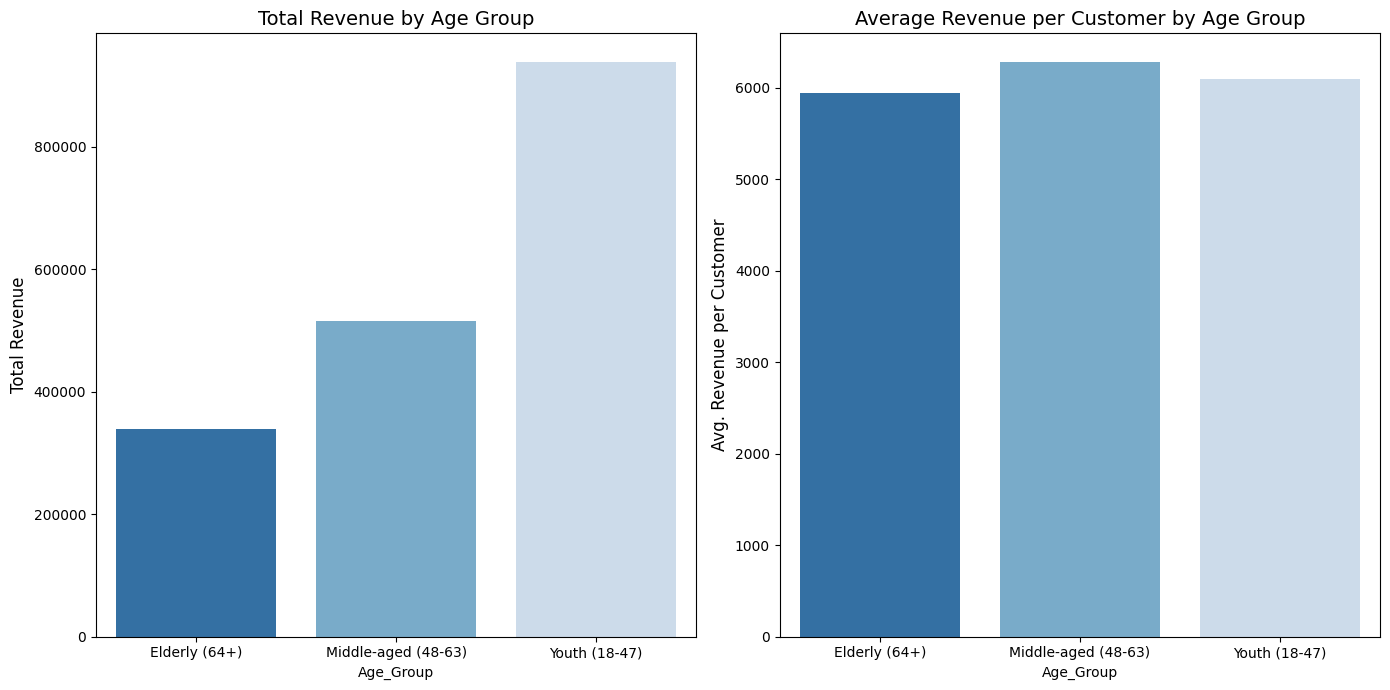


Most significant age group based on revenue: Youth (18-47)
Number of transactions in Youth (18-47) group: 14435

--- OCCUPATION ANALYSIS ---
Top 10 Occupations by Revenue:
              CustomerID    Revenue
Occupation                         
Teacher               21  150538.14
Doctor                21  122512.35
Salesperson           18  122035.49
Entrepreneur          21  119876.00
Nurse                 11  105783.55
Manager               17   96078.04
Artist                18   87435.90
Lawyer                15   71873.05
Engineer              12   62555.39


<ipython-input-7-2c8be43fe8eb>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Occupation', x='Revenue', data=top_occupations_reset, palette="Blues_r")


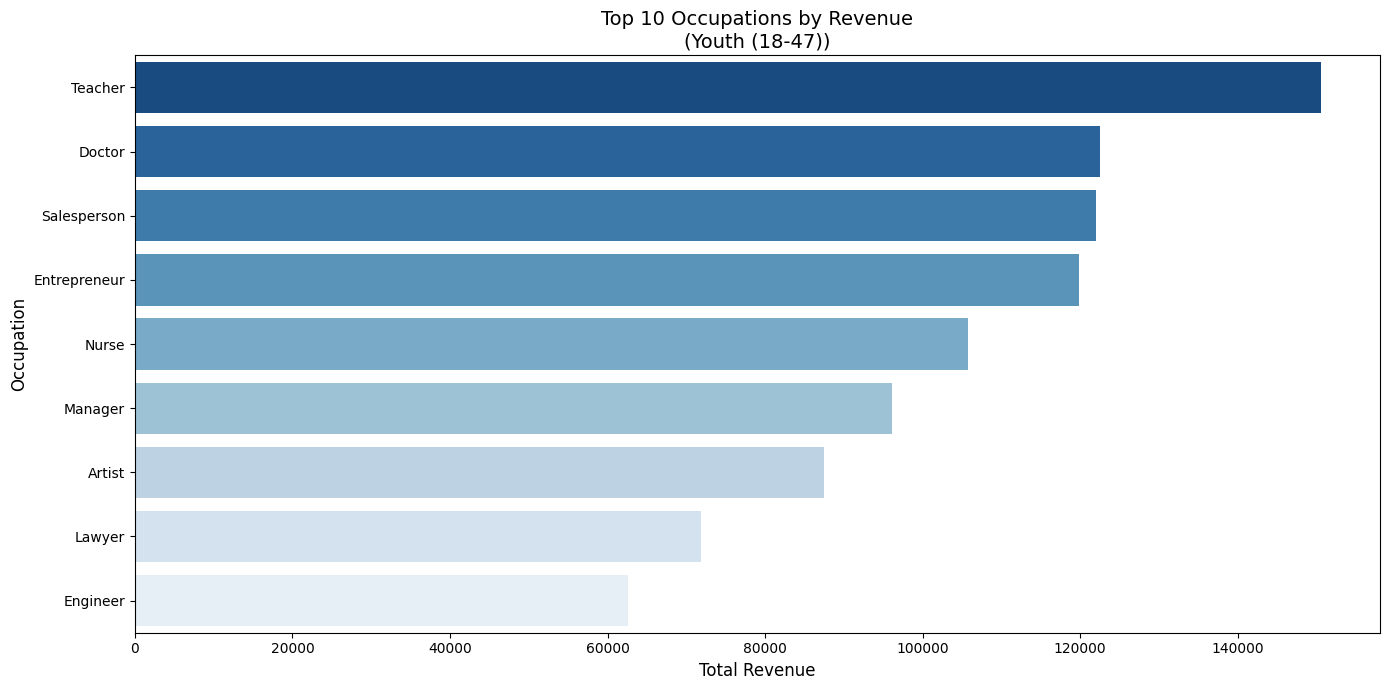


--- PREFERRED LANGUAGE ---


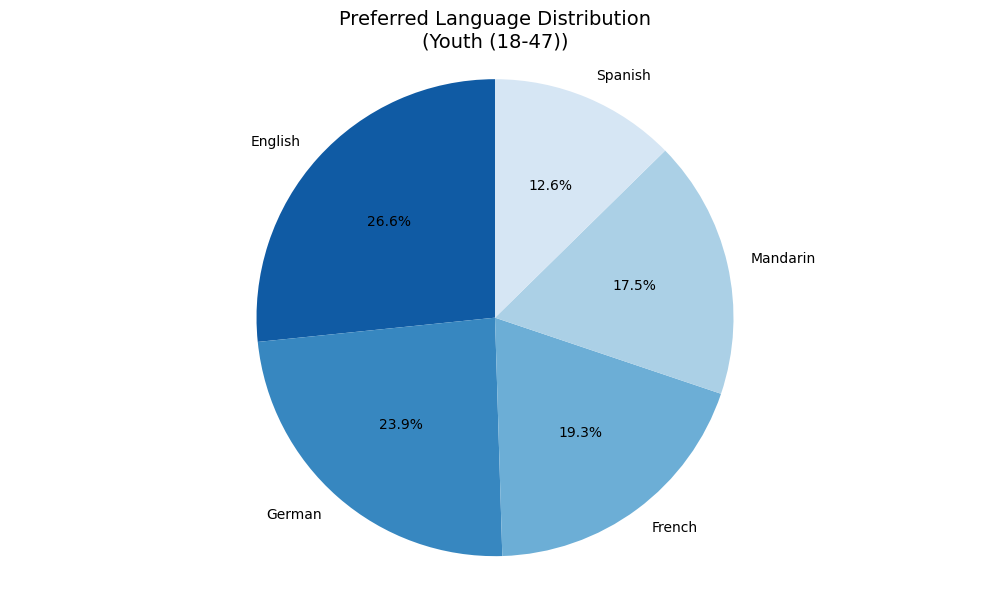


=== SUMMARY OF KEY FINDINGS ===
1. The most significant age group is: Youth (18-47)
2. Top occupation: Teacher
5. Preferred language: English


In [ ]:
sns.set_palette("Blues_r")

high_value_customers = pd.read_csv('high_value_customers.csv')
high_value_ids = high_value_customers['CustomerID'].tolist()

# Filter for high-value customers only
df_analysis = customer_sales[customer_sales['CustomerID'].isin(high_value_ids)]

# 1. Age Group Analysis
print("\n--- AGE GROUP ANALYSIS ---")

# Create age groups as specified: 18-47 (youth), 48-63 (middle-aged), and 64+ (elderly)
def categorize_age(age):
    if age < 48:
        return 'Youth (18-47)'
    elif age < 64:
        return 'Middle-aged (48-63)'
    else:
        return 'Elderly (64+)'

df_analysis['Age_Group'] = df_analysis['Age'].apply(categorize_age)

# Analyze spending by age group
age_group_spending = df_analysis.groupby('Age_Group').agg({
    'CustomerID': 'nunique',
    'Transaction_ID': 'count',
    'Revenue': 'sum'
}).reset_index()

age_group_spending['Avg_Revenue_Per_Customer'] = age_group_spending['Revenue'] / age_group_spending['CustomerID']
age_group_spending['Avg_Transaction_Value'] = age_group_spending['Revenue'] / age_group_spending['Transaction_ID']
age_group_spending['Transactions_Per_Customer'] = age_group_spending['Transaction_ID'] / age_group_spending['CustomerID']

print("Spending by Age Group:")
print(age_group_spending)

# Visualize age group spending
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='Age_Group', y='Revenue', data=age_group_spending, palette="Blues_r")
plt.title('Total Revenue by Age Group', fontsize=14)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
sns.barplot(x='Age_Group', y='Avg_Revenue_Per_Customer', data=age_group_spending, palette="Blues_r")
plt.title('Average Revenue per Customer by Age Group', fontsize=14)
plt.ylabel('Avg. Revenue per Customer', fontsize=12)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Determine the most significant age group based on total revenue
significant_age_group = age_group_spending.loc[age_group_spending['Revenue'].idxmax(), 'Age_Group']
print(f"\nMost significant age group based on revenue: {significant_age_group}")

# Filter for the most significant age group
sig_age_df = df_analysis[df_analysis['Age_Group'] == significant_age_group]
print(f"Number of transactions in {significant_age_group} group: {len(sig_age_df)}")

# 2. Occupation Analysis for significant age group
print("\n--- OCCUPATION ANALYSIS ---")

# Get top 10 occupations by revenue
top_occupations = sig_age_df.groupby('Occupation').agg({
    'CustomerID': 'nunique',
    'Revenue': 'sum'
}).sort_values('Revenue', ascending=False).head(10)

print("Top 10 Occupations by Revenue:")
print(top_occupations)

# Visualize top occupations
plt.figure(figsize=(14, 7))
# Use Seaborn's barplot for horizontal bars with the Blues_r palette
top_occupations_reset = top_occupations.reset_index()
sns.barplot(y='Occupation', x='Revenue', data=top_occupations_reset, palette="Blues_r")
plt.title(f'Top 10 Occupations by Revenue\n({significant_age_group})', fontsize=14)
plt.xlabel('Total Revenue', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Optional: Preferred Language
print("\n--- PREFERRED LANGUAGE ---")
language_pref = sig_age_df['Preferred Language'].value_counts()


# Create a pie chart for language preferences
plt.figure(figsize=(10, 6))
# Get colors for language pie chart
lang_colors = sns.color_palette("Blues_r", len(language_pref))

plt.pie(language_pref, labels=language_pref.index, autopct='%1.1f%%',
        startangle=90, shadow=False, colors=lang_colors)
plt.title(f'Preferred Language Distribution\n({significant_age_group})', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Summary of key findings
print("\n=== SUMMARY OF KEY FINDINGS ===")
print(f"1. The most significant age group is: {significant_age_group}")
print(f"2. Top occupation: {top_occupations.index[0]}")
print(f"5. Preferred language: {language_pref.index[0]}")


--- CUSTOMER INTERACTION AND PREFERENCES ---


<ipython-input-8-939bd343c785>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis_2['Age_Group'] = df_analysis_2['Age'].apply(categorize_age)


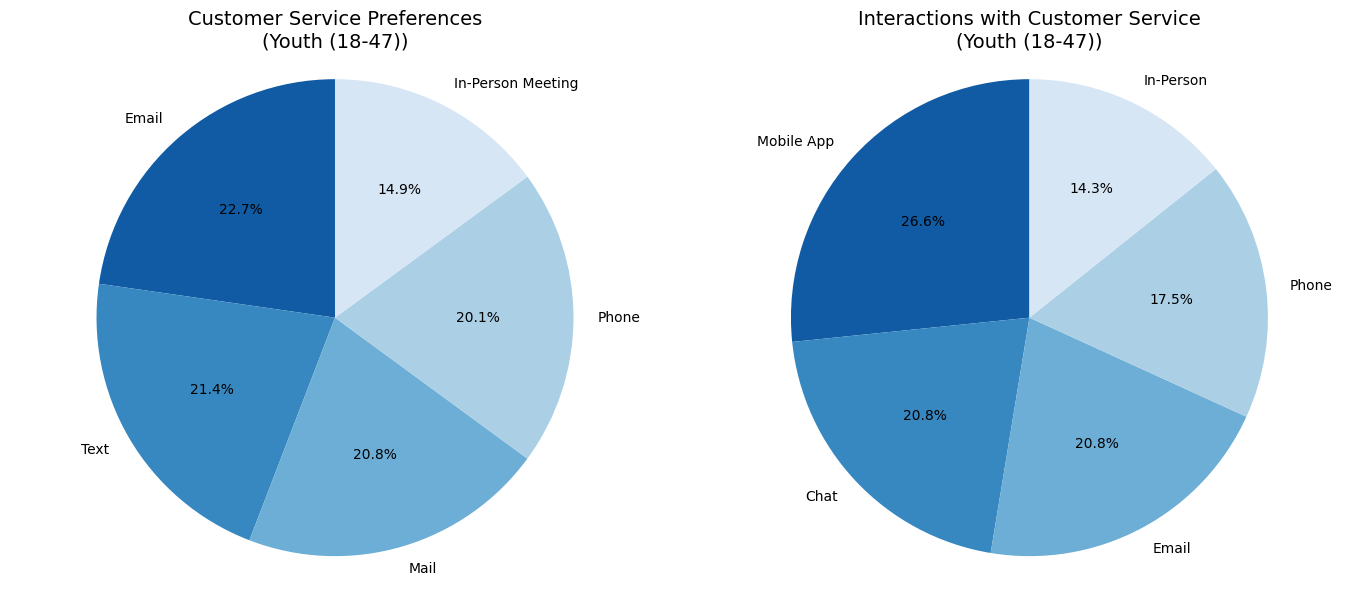

In [ ]:
# Filter for high-value customers only
df_analysis_2 = customer_profile[customer_profile['CustomerID'].isin(high_value_ids)]
df_analysis_2['Age_Group'] = df_analysis_2['Age'].apply(categorize_age)
sig_age_df_2 = df_analysis_2[df_analysis_2['Age_Group'] == 'Youth (18-47)']
# 3. Customer Interaction and Preferences
print("\n--- CUSTOMER INTERACTION AND PREFERENCES ---")

# Analyze customer service interactions
service_interactions = sig_age_df_2['Customer Preferences'].value_counts()

# Analyze Interaction with Customer Service
contact_time = sig_age_df_2['Interactions with Customer Service'].value_counts()

# Visualize interaction vs. preferences
plt.figure(figsize=(14, 6))

# Get colors from the Blues_r palette for pie charts
colors = sns.color_palette("Blues_r", len(service_interactions))

plt.subplot(1, 2, 1)
plt.pie(service_interactions, labels=service_interactions.index, autopct='%1.1f%%',
        startangle=90, shadow=False, colors=colors)
plt.title(f'Customer Service Preferences\n({significant_age_group})', fontsize=14)
plt.axis('equal')

# Get colors for the second pie chart
colors2 = sns.color_palette("Blues_r", len(contact_time))

plt.subplot(1, 2, 2)
plt.pie(contact_time, labels=contact_time.index, autopct='%1.1f%%',
        startangle=90, shadow=False, colors=colors2)
plt.title(f'Interactions with Customer Service\n({significant_age_group})', fontsize=14)
plt.axis('equal')

plt.tight_layout()
plt.show()



--- PREFERRED TIME ANALYSIS ---
Transactions by Day of Week:
           Transaction_ID    Revenue
DayOfWeek                           
Monday               1552  102063.92
Tuesday              1356   88910.60
Wednesday            2823  202413.08
Thursday             2036  137161.35
Friday               2175  130296.12
Saturday             2329  142858.64
Sunday               2164  134984.20


<ipython-input-9-8f4d9669b0d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_age_df['Transaction_Date'] = pd.to_datetime(sig_age_df['Transaction_Date'])
<ipython-input-9-8f4d9669b0d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_age_df['DayOfWeek'] = sig_age_df['Transaction_Date'].dt.day_name()


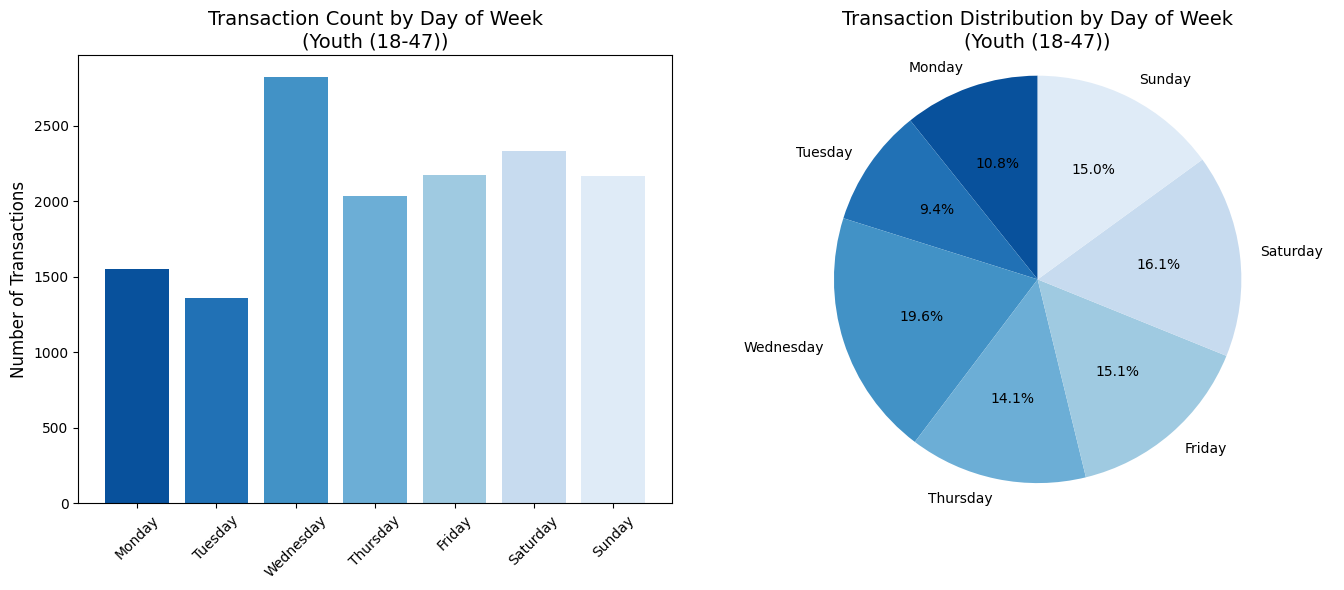

In [ ]:
# 5. Preferred Time Analysis
print("\n--- PREFERRED TIME ANALYSIS ---")

# First, convert Transaction_Date to datetime and extract day of week
# Make sure sig_age_df is created with the correct Transaction_Date column
sig_age_df['Transaction_Date'] = pd.to_datetime(sig_age_df['Transaction_Date'])
sig_age_df['DayOfWeek'] = sig_age_df['Transaction_Date'].dt.day_name()

# Day of Week Analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_analysis = sig_age_df.groupby('DayOfWeek').agg({
    'Transaction_ID': 'count',
    'Revenue': 'sum'
}).reindex(day_order)

print("Transactions by Day of Week:")
print(day_analysis)

# Create a Blues_r color palette
blues_r_palette = sns.color_palette("Blues_r", len(day_order))

# Visualize day of week preference
plt.figure(figsize=(14, 6))

# Bar chart
plt.subplot(1, 2, 1)
plt.bar(day_analysis.index, day_analysis['Transaction_ID'], color=blues_r_palette)
plt.title(f'Transaction Count by Day of Week\n({significant_age_group})', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(day_analysis['Transaction_ID'],
        labels=day_analysis.index,
        autopct='%1.1f%%',
        startangle=90,
        shadow=False,
        colors=blues_r_palette)
plt.title(f'Transaction Distribution by Day of Week\n({significant_age_group})', fontsize=14)
plt.axis('equal')

plt.tight_layout()
plt.show()

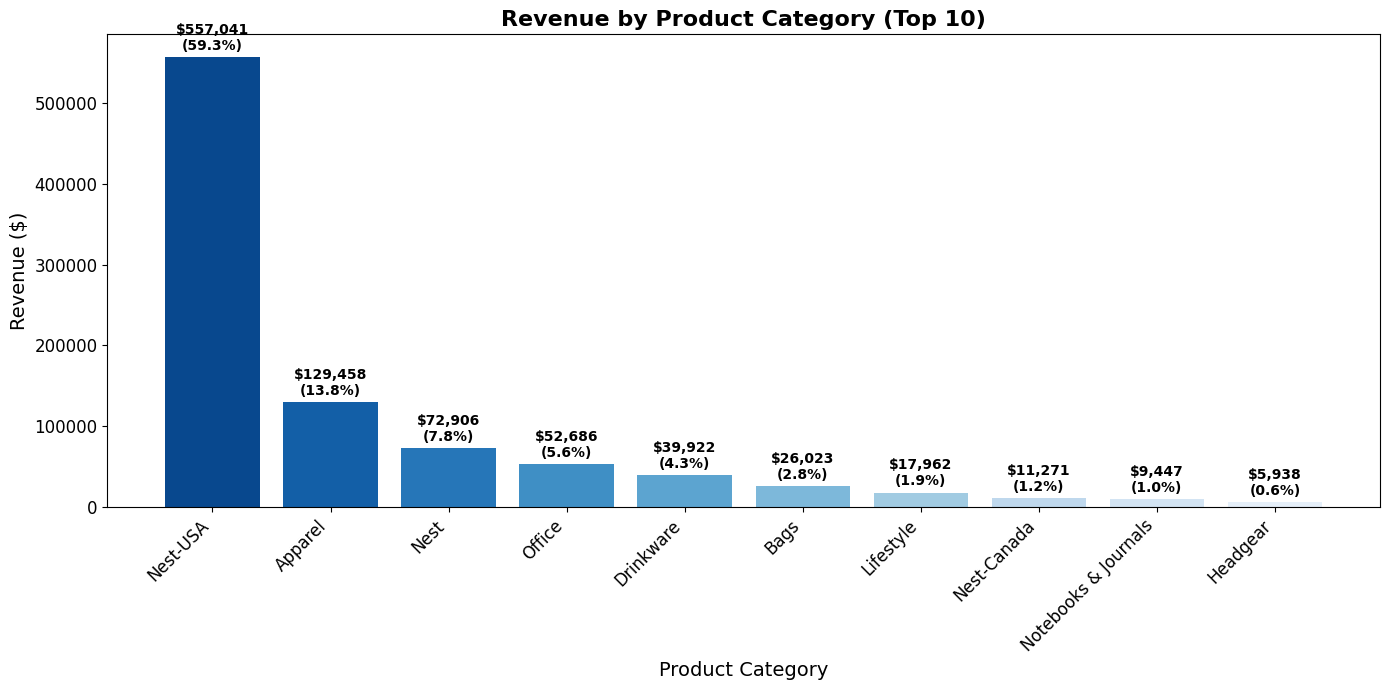

In [ ]:
# Replace customer_sales with sig_age_df
category_performance = sig_age_df.groupby('Product_Category').agg({
    'Revenue': 'sum',
    'Transaction_ID': 'nunique'
}).reset_index()
category_performance = category_performance.sort_values('Revenue', ascending=False)
category_performance['Revenue_Percentage'] = category_performance['Revenue'] / category_performance['Revenue'].sum() * 100

# Select top 10 categories
top_10_categories = category_performance.head(10)

# Create a visually engaging bar chart with Blues_r palette
plt.figure(figsize=(14, 7))

# Get colors from Blues_r palette
blues_colors = sns.color_palette("Blues_r", len(top_10_categories))

# Create the bar chart
bars = plt.bar(top_10_categories['Product_Category'], top_10_categories['Revenue'], color=blues_colors)
plt.title('Revenue by Product Category (Top 10)', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Revenue ($)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add percentage labels for top 10
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5000,
             f'${height:,.0f}\n({top_10_categories.iloc[i]["Revenue_Percentage"]:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Section 2: Marketing Analysis**

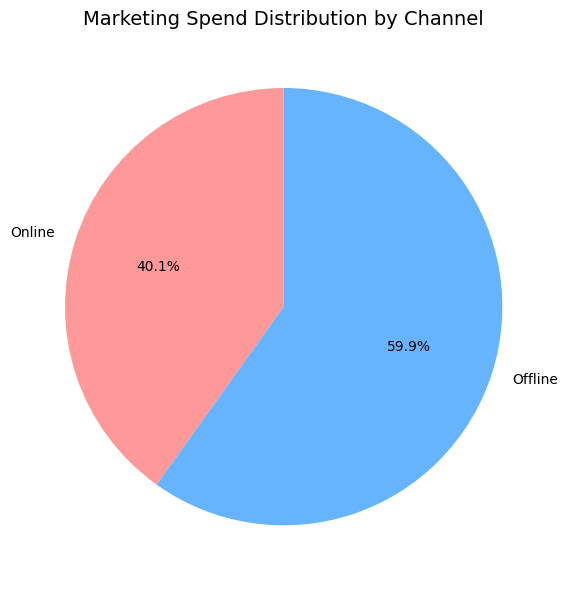

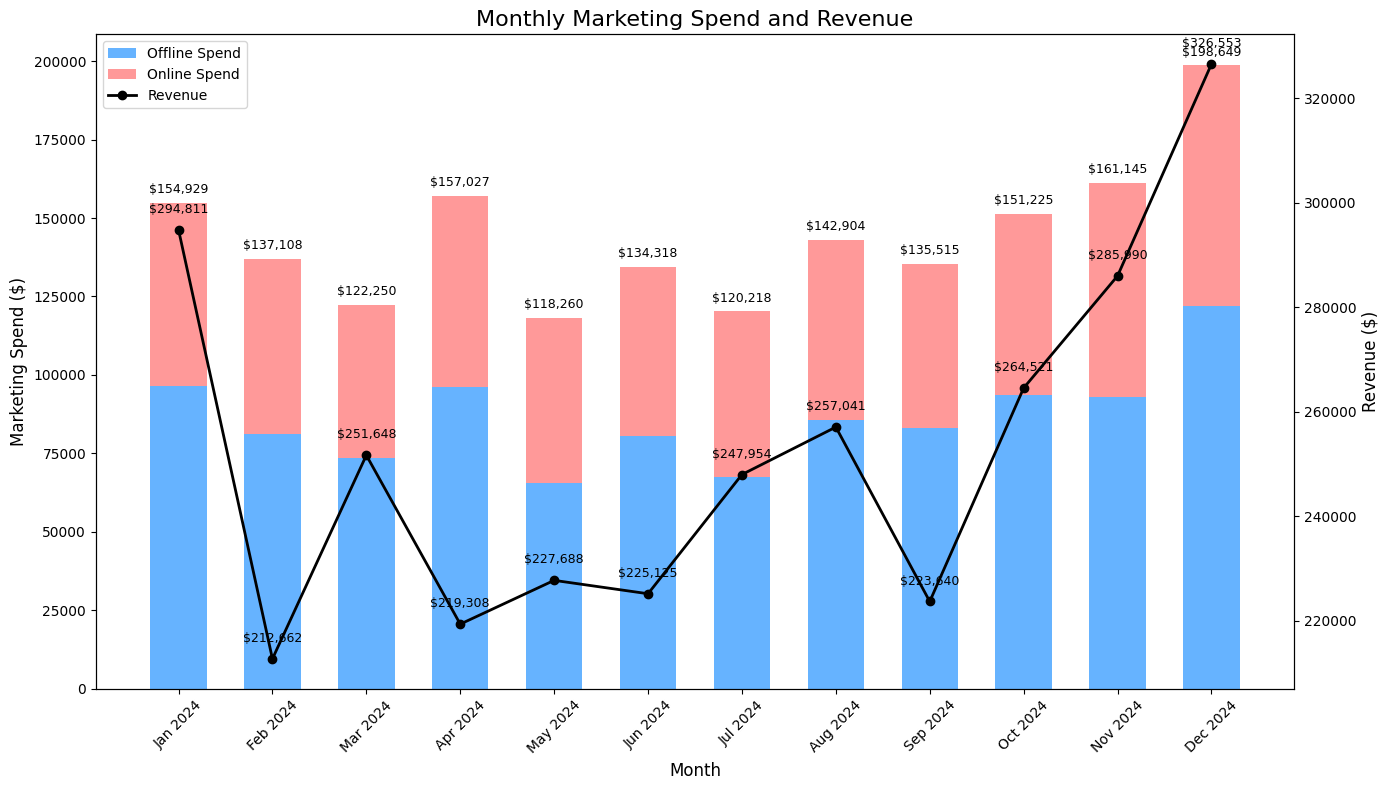

In [ ]:
# 1. MARKETING CHANNEL ANALYSIS
# Monthly marketing spend by channel
monthly_marketing = marketing_spend.groupby(['Year', 'Month']).agg({
    'Online_Spend': 'sum',
    'Offline_Spend': 'sum'
}).reset_index()

monthly_marketing['Total_Spend'] = monthly_marketing['Online_Spend'] + monthly_marketing['Offline_Spend']
monthly_marketing['Online_Percentage'] = (monthly_marketing['Online_Spend'] / monthly_marketing['Total_Spend']) * 100
monthly_marketing['Offline_Percentage'] = (monthly_marketing['Offline_Spend'] / monthly_marketing['Total_Spend']) * 100
monthly_marketing['Date'] = pd.to_datetime(monthly_marketing['Year'].astype(str) + '-' + monthly_marketing['Month'].astype(str) + '-01')

# Calculate channel distribution
channel_distribution = pd.DataFrame({
    'Channel': ['Online', 'Offline'],
    'Spend': [monthly_marketing['Online_Spend'].sum(), monthly_marketing['Offline_Spend'].sum()]
})
channel_distribution['Percentage'] = (channel_distribution['Spend'] / channel_distribution['Spend'].sum()) * 100

# Create pie chart of marketing spend distribution
plt.figure(figsize=(10, 6))
plt.pie(channel_distribution['Percentage'],
        labels=channel_distribution['Channel'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff'])
plt.title('Marketing Spend Distribution by Channel', fontsize=14)
plt.tight_layout()
plt.show()


# 2. Monthly marketing spend vs revenue
# Create Month-Year label
monthly_marketing['Month_Year'] = pd.to_datetime(monthly_marketing['Year'].astype(str) + '-' +
                                              monthly_marketing['Month'].astype(str) + '-01').dt.strftime('%b %Y')

# Calculate total spend
monthly_marketing['Total_Spend'] = monthly_marketing['Online_Spend'] + monthly_marketing['Offline_Spend']

# Aggregate monthly revenue from customer sales
monthly_revenue = customer_sales.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()

# Merge datasets
combined_data = pd.merge(monthly_marketing, monthly_revenue, on=['Year', 'Month'], how='inner')

# Sort chronologically
combined_data = combined_data.sort_values(['Year', 'Month'])

# Keep only the most recent 12 months
if len(combined_data) > 12:
    combined_data = combined_data.tail(12)

# Create the visualization
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar positions
x = np.arange(len(combined_data))
width = 0.6

# Create stacked bars
offline_bars = ax1.bar(x, combined_data['Offline_Spend'], width, color='#66b3ff', label='Offline Spend')
online_bars = ax1.bar(x, combined_data['Online_Spend'], width, bottom=combined_data['Offline_Spend'],
                    color='#ff9999', label='Online Spend')

# Add revenue line on secondary axis
ax2 = ax1.twinx()
revenue_line = ax2.plot(x, combined_data['Revenue'], 'k-', linewidth=2, marker='o', label='Revenue')

# Set titles and labels
ax1.set_title('Monthly Marketing Spend and Revenue', fontsize=16)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Marketing Spend ($)', fontsize=12)
ax2.set_ylabel('Revenue ($)', fontsize=12)

# Format x-axis
ax1.set_xticks(x)
ax1.set_xticklabels(combined_data['Month_Year'], rotation=45)

# Add data labels for total spend
for i, total in enumerate(combined_data['Total_Spend']):
    ax1.annotate(f'${total:,.0f}',
                xy=(i, total),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

# Add data labels for revenue
for i, revenue in enumerate(combined_data['Revenue']):
    ax2.annotate(f'${revenue:,.0f}',
                xy=(i, revenue),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9,
                color='black')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Add formatting for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Calculate ROI
test1 = ((monthly_revenue['Revenue'] - monthly_marketing['Online_Spend']) / monthly_marketing['Online_Spend']).aggregate('mean')
test2 = ((monthly_revenue['Revenue'] - monthly_marketing['Offline_Spend']) / monthly_marketing['Offline_Spend']).aggregate('mean')
print(test1)
print(test2)

3.3832136803792454
1.9669758309836192


<ipython-input-13-97aab11d5d20>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Coupon_Status', y='Percentage', data=coupon_usage, palette="Blues_r")


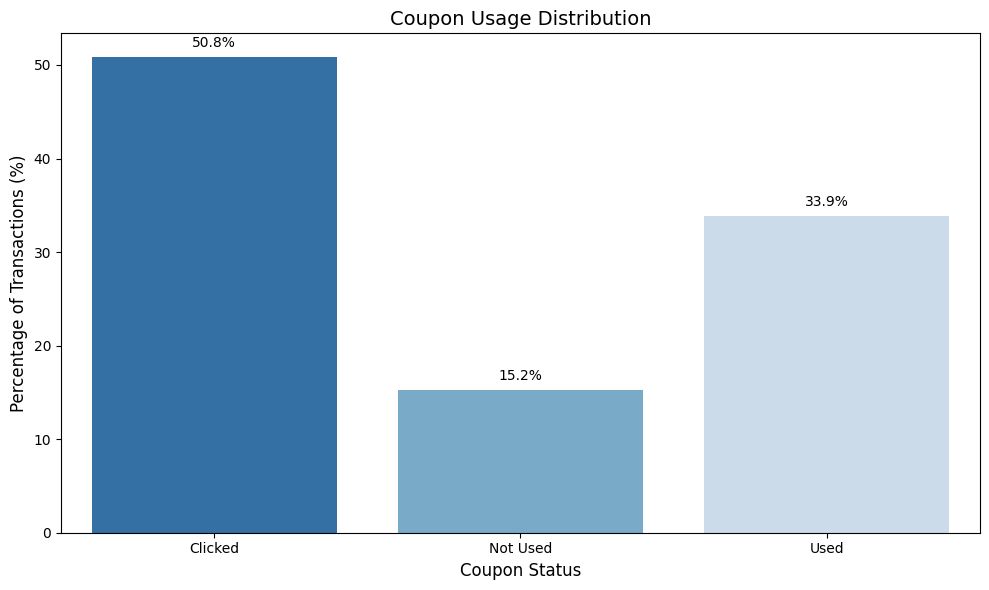

<ipython-input-13-97aab11d5d20>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Coupon_Status', y='Revenue', data=coupon_revenue, palette="Blues_r")


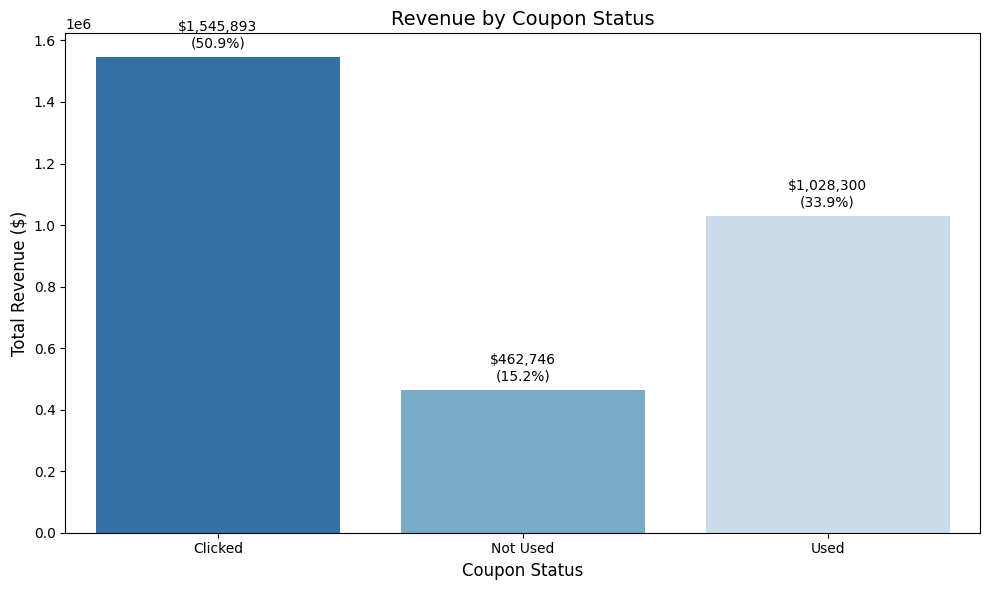

In [ ]:
# 3. DISCOUNT COUPON ANALYSIS

# Convert month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
discount_coupon['Month_Num'] = discount_coupon['Month'].map(month_map)

# Coupon usage analysis
coupon_usage = customer_sales.groupby('Coupon_Status')['Transaction_ID'].count().reset_index()
coupon_usage['Percentage'] = (coupon_usage['Transaction_ID'] / coupon_usage['Transaction_ID'].sum()) * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coupon_Status', y='Percentage', data=coupon_usage, palette="Blues_r")
plt.title('Coupon Usage Distribution', fontsize=14)
plt.xlabel('Coupon Status', fontsize=12)
plt.ylabel('Percentage of Transactions (%)', fontsize=12)

# Add data labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%',
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'bottom',
               xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Coupon effect on revenue
coupon_revenue = customer_sales.groupby('Coupon_Status')['Revenue'].sum().reset_index()
coupon_revenue['Percentage'] = (coupon_revenue['Revenue'] / coupon_revenue['Revenue'].sum()) * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coupon_Status', y='Revenue', data=coupon_revenue, palette="Blues_r")
plt.title('Revenue by Coupon Status', fontsize=14)
plt.xlabel('Coupon Status', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)

# Add data labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'${p.get_height():,.0f}\n({coupon_revenue["Percentage"][i]:.1f}%)',
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'bottom',
               xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [ ]:
coupon_usage

,Coupon_Status,Transaction_ID,Percentage
0,Clicked,25061,50.841922
1,Not Used,7517,15.249939
2,Used,16714,33.908139


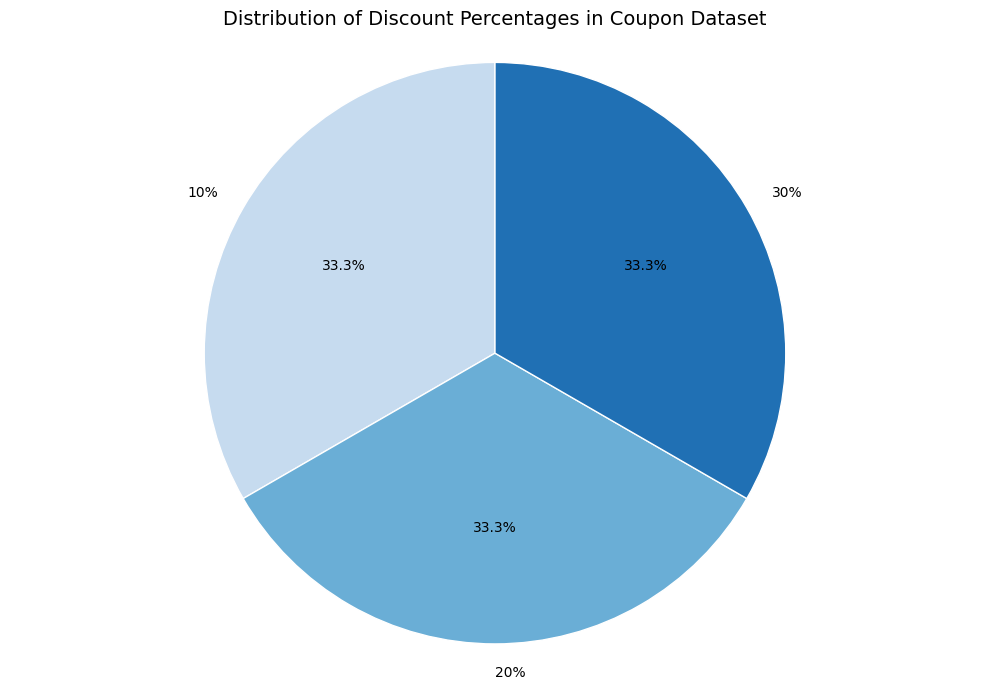

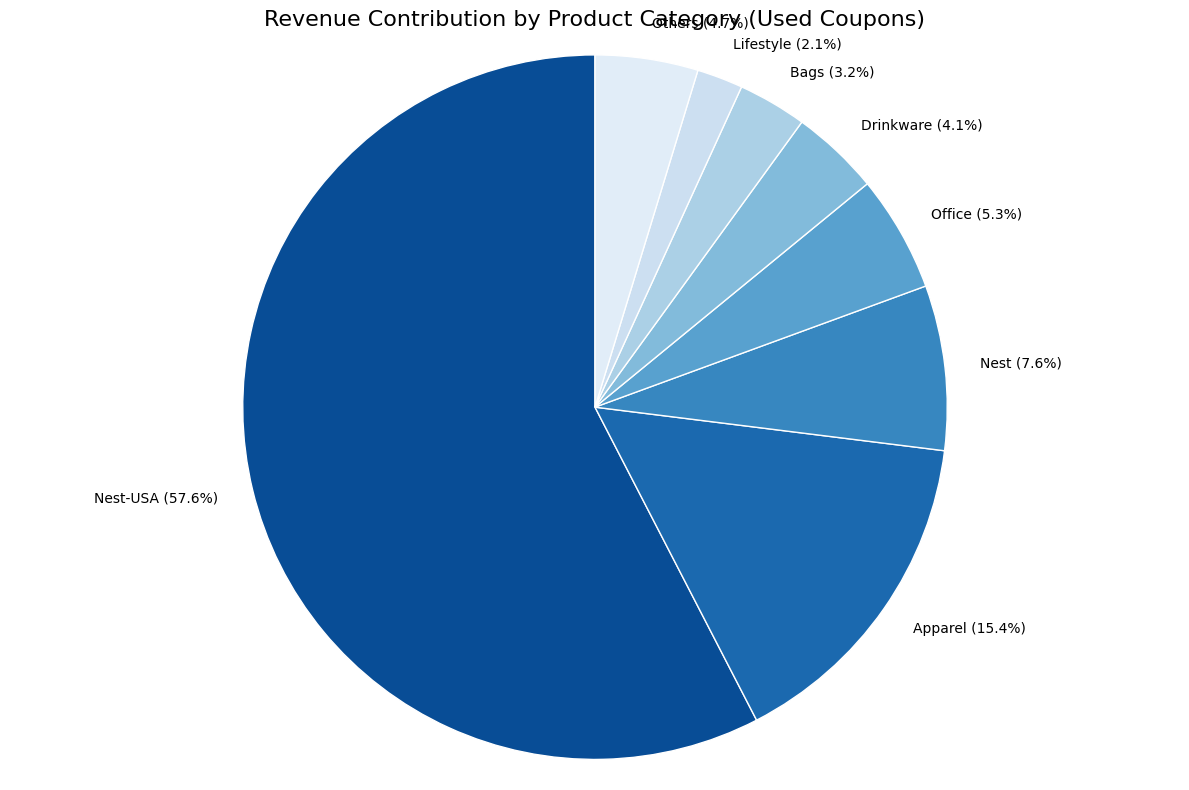


Revenue Contribution by Product Category (Used Coupons):
                                  Category  Revenue ($)  Percentage (%)
Product_Category                                                       
Nest-USA                          Nest-USA    592156.55       57.585978
Apparel                            Apparel    158762.36       15.439305
Nest                                  Nest     77769.10        7.562881
Office                              Office     54977.82        5.346477
Drinkware                        Drinkware     41910.99        4.075756
Bags                                  Bags     32494.80        3.160051
Lifestyle                        Lifestyle     21708.25        2.111082
Nest-Canada                    Nest-Canada     11691.94        1.137017
Notebooks & Journals  Notebooks & Journals     11040.79        1.073694
Gift Cards                      Gift Cards      7499.03        0.729265


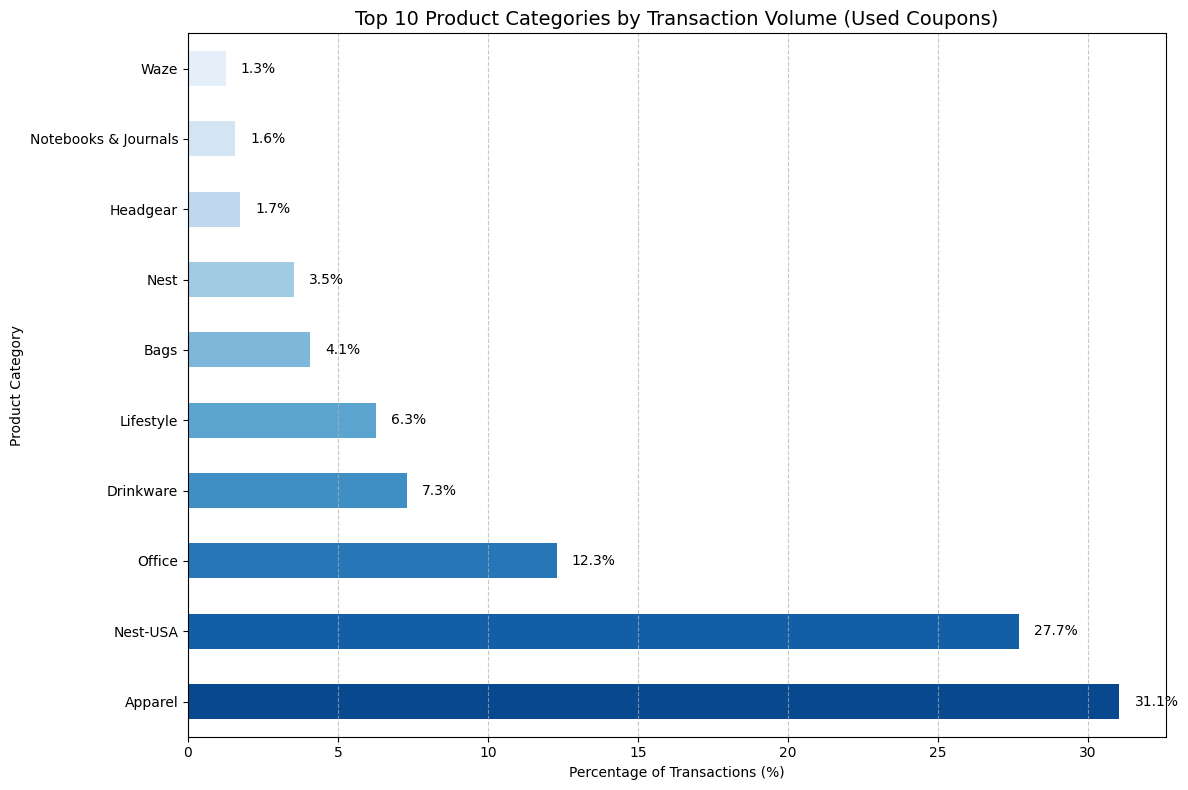

In [ ]:
# 1. Create a distribution of discount percentages in the discount_coupon dataset
discount_distribution = discount_coupon['Discount_pct'].value_counts(normalize=True) * 100
discount_distribution = discount_distribution.reset_index()
discount_distribution.columns = ['Discount_pct', 'Percentage']

# 2. Create a pie chart for discount percentage distribution
plt.figure(figsize=(10, 7))
plt.pie(discount_distribution['Percentage'],
        labels=[f"{int(pct)}%" for pct in discount_distribution['Discount_pct']],
        autopct='%1.1f%%',
        colors=sns.color_palette('Blues', len(discount_distribution)),
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('Distribution of Discount Percentages in Coupon Dataset', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

# 3. Analyze revenue contribution by product category for transactions with used coupons
used_coupon_transactions = customer_sales[customer_sales['Coupon_Status'] == 'Used']

# Calculate revenue by category
revenue_by_category = used_coupon_transactions.groupby('Product_Category')['Revenue'].sum()
total_revenue = revenue_by_category.sum()
revenue_percentage = (revenue_by_category / total_revenue * 100).sort_values(ascending=False)

# Keep top 7 categories, group others
top_categories = revenue_percentage.head(7)
other_categories = pd.Series([revenue_percentage[7:].sum()], index=['Others'])
revenue_pie_data = pd.concat([top_categories, other_categories])

# Create pie chart for revenue contribution
plt.figure(figsize=(12, 8))
plt.pie(revenue_pie_data,
        labels=[f"{cat} ({val:.1f}%)" for cat, val in revenue_pie_data.items()],
        colors=sns.color_palette('Blues_r', len(revenue_pie_data)),
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('Revenue Contribution by Product Category (Used Coupons)', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Optional: Create a table to show exact numbers
print("\nRevenue Contribution by Product Category (Used Coupons):")
revenue_table = pd.DataFrame({
    'Category': revenue_percentage.index,
    'Revenue ($)': revenue_by_category[revenue_percentage.index],
    'Percentage (%)': revenue_percentage.values
})
print(revenue_table.head(10))

# Optional: Additional analysis to show transaction count by category
transactions_by_category = used_coupon_transactions.groupby('Product_Category')['Transaction_ID'].nunique()
transactions_percentage = (transactions_by_category / transactions_by_category.sum() * 100).sort_values(ascending=False)

# Create a horizontal bar chart for top 10 categories by transaction volume
plt.figure(figsize=(12, 8))
transactions_percentage.head(10).plot(kind='barh', color=sns.color_palette('Blues_r', 10))
plt.xlabel('Percentage of Transactions (%)')
plt.ylabel('Product Category')
plt.title('Top 10 Product Categories by Transaction Volume (Used Coupons)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels to the bars
for i, v in enumerate(transactions_percentage.head(10)):
    plt.text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# 1. Prepare the data
monthly_online_spend = marketing_spend.groupby(['Year', 'Month'])['Online_Spend'].sum().reset_index()
monthly_offline_spend = marketing_spend.groupby(['Year', 'Month'])['Offline_Spend'].sum().reset_index()
monthly_revenue = customer_sales.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()

# Merge the data
marketing_roi = pd.merge(monthly_online_spend, monthly_offline_spend, on=['Year', 'Month'], how='outer')
marketing_roi = pd.merge(marketing_roi, monthly_revenue, on=['Year', 'Month'], how='outer')
marketing_roi['Date'] = pd.to_datetime(marketing_roi['Year'].astype(str) + '-' + marketing_roi['Month'].astype(str), format='%Y-%m')

In [ ]:
# Calculate ROI for Online and Offline marketing
marketing_roi['Online_ROI'] = (marketing_roi['Revenue'] - marketing_roi['Online_Spend']) / marketing_roi['Online_Spend']
marketing_roi['Offline_ROI'] = (marketing_roi['Revenue'] - marketing_roi['Offline_Spend']) / marketing_roi['Offline_Spend']

# Replace infinite values with NaN (to avoid issues in plotting)
marketing_roi.replace([np.inf, -np.inf], np.nan, inplace=True)
print (marketing_roi['Online_ROI'])
print (marketing_roi['Offline_ROI'])

0     4.054285
1     2.810606
2     4.162008
3     2.593627
4     3.315565
5     3.183062
6     3.703411
7     3.477734
8     3.258635
9     3.582454
10    3.196796
11    3.260381
Name: Online_ROI, dtype: float64
0     2.051875
1     1.615769
2     2.423787
3     1.284455
4     2.476147
5     1.796579
6     2.673389
7     2.006322
8     1.694461
9     1.829097
10    2.075167
11    1.676663
Name: Offline_ROI, dtype: float64


**Section 3: Landing pages**

Actual landing page values: ['/us/landing_page_1' '/us/landing_page_2']


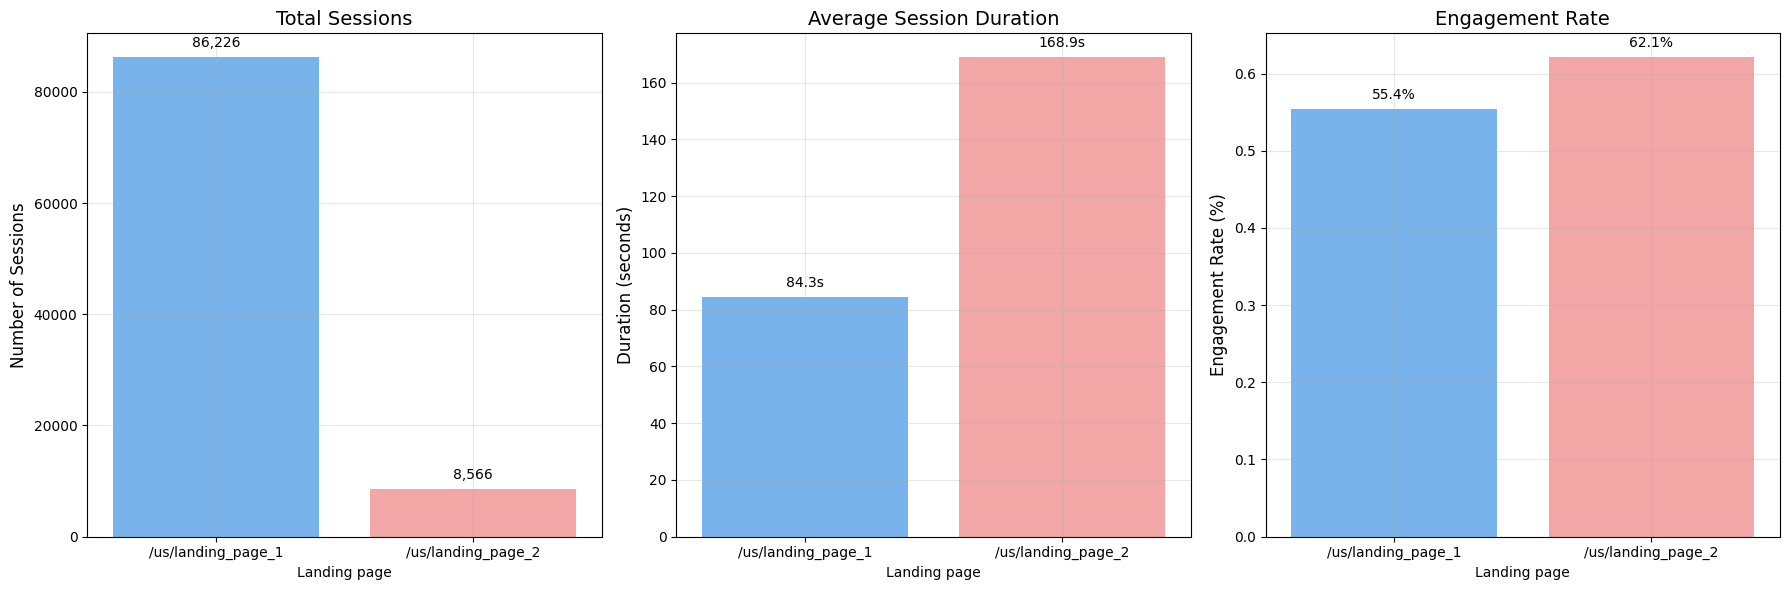

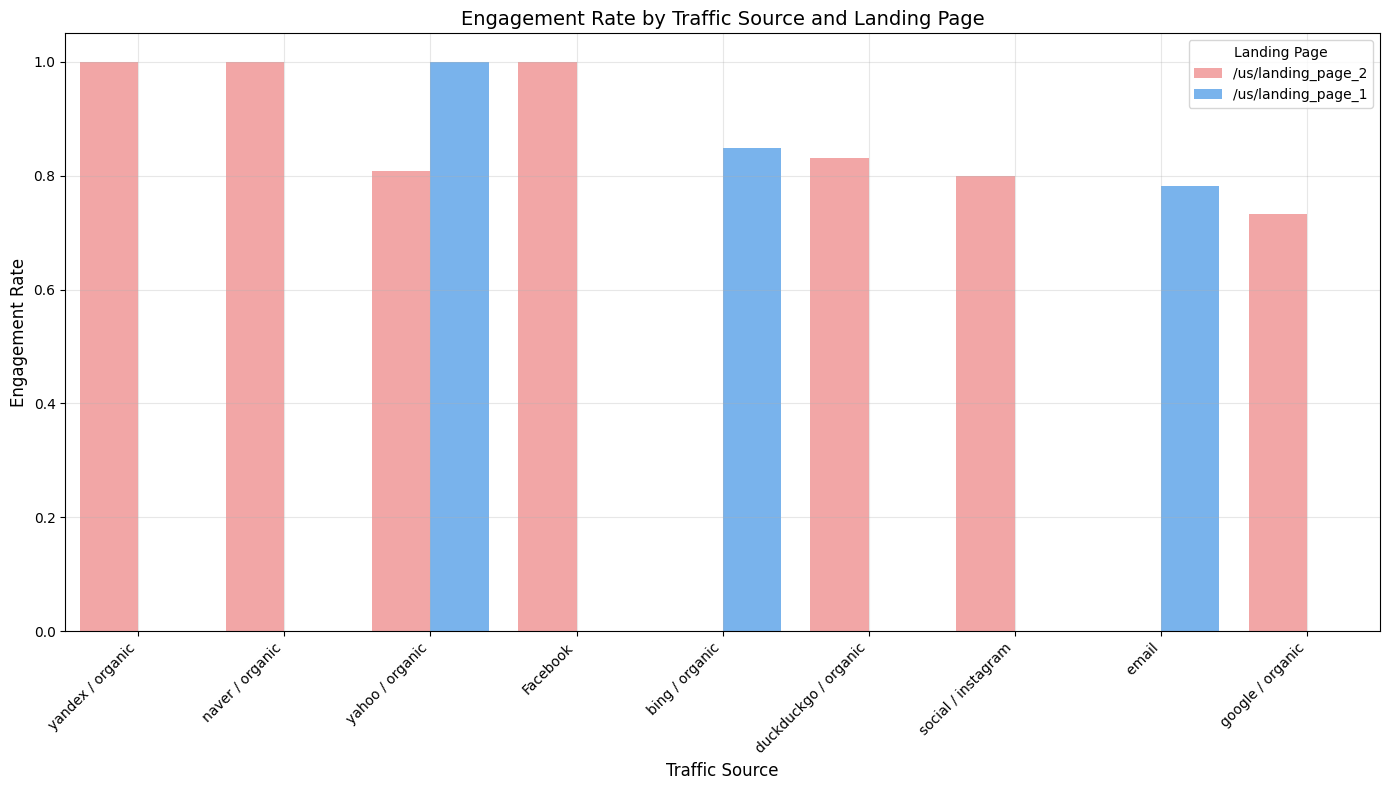

In [ ]:
# 4. LANDING PAGE A/B TESTING ANALYSIS
# First, check the actual landing page values in your dataset
unique_landing_pages = landing_pages['Landing page'].unique()
print(f"Actual landing page values: {unique_landing_pages}")

# Define the specific colors for the actual landing page values
page_colors = {unique_landing_pages[0]: '#66b3ff', unique_landing_pages[1]: '#ff9999'}

# Compare key metrics between landing pages
landing_comparison = landing_pages.groupby('Landing page').agg({
    'Sessions': 'sum',
    'Average session duration': 'mean',
    'Engagement rate': 'mean'
}).reset_index()

# Create a comparison chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sessions comparison - use hue instead of just x (to fix the deprecation warning)
sns.barplot(x='Landing page', y='Sessions', data=landing_comparison, ax=axes[0],
            hue='Landing page', palette=page_colors, legend=False)
axes[0].set_title('Total Sessions', fontsize=14)
axes[0].set_ylabel('Number of Sessions', fontsize=12)
axes[0].grid(True, alpha=0.3)
# Add data labels
for i, p in enumerate(axes[0].patches):
    axes[0].annotate(f'{int(p.get_height()):,}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  xytext = (0, 5), textcoords = 'offset points')

# Duration comparison
sns.barplot(x='Landing page', y='Average session duration', data=landing_comparison, ax=axes[1],
            hue='Landing page', palette=page_colors, legend=False)
axes[1].set_title('Average Session Duration', fontsize=14)
axes[1].set_ylabel('Duration (seconds)', fontsize=12)
axes[1].grid(True, alpha=0.3)
# Add data labels
for i, p in enumerate(axes[1].patches):
    axes[1].annotate(f'{p.get_height():.1f}s',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  xytext = (0, 5), textcoords = 'offset points')

# Engagement rate comparison
sns.barplot(x='Landing page', y='Engagement rate', data=landing_comparison, ax=axes[2],
            hue='Landing page', palette=page_colors, legend=False)
axes[2].set_title('Engagement Rate', fontsize=14)
axes[2].set_ylabel('Engagement Rate (%)', fontsize=12)
axes[2].grid(True, alpha=0.3)
# Add data labels
for i, p in enumerate(axes[2].patches):
    axes[2].annotate(f'{p.get_height()*100:.1f}%',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Performance by traffic source
source_performance = landing_pages.groupby(['Landing page', 'Session source_medium']).agg({
    'Sessions': 'sum',
    'Average session duration': 'mean',
    'Engagement rate': 'mean'
}).reset_index()

source_performance_top = source_performance.sort_values(by=['Engagement rate'], ascending=False).head(10)

# Plot engagement rate by traffic source for each landing page
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Session source_medium', y='Engagement rate', hue='Landing page',
                data=source_performance_top,
                palette=page_colors)
plt.title('Engagement Rate by Traffic Source and Landing Page', fontsize=14)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Engagement Rate', fontsize=12)
plt.legend(title='Landing Page')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()